<a href="https://colab.research.google.com/github/Raj123majumder/MINI_PROJECT_NLP_2/blob/main/fake_news_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1 MB 1.7 kB/s 
     |████████████████████████████████| 8.8 MB 21.9 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.2.0+cu92 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.2.0+cu92 which is incompatible.


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
#from torchtext.data.utils import get_tokenizer
#from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [4]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv('/content/test.csv')

In [5]:
df_train.shape

(20800, 5)

In [6]:
df_train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [8]:
df_train.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [9]:
df_test.isna().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [10]:
df_train = df_train.fillna('')
df_test = df_test.fillna('')

In [11]:
df_train.isna().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [12]:
df_train['total'] = df_train['title'] + df_train['author']
df_test['total'] = df_test['title'] + df_test['author']

In [13]:
unreliable_count =len(df_train[df_train['label']==1])
reliable_count = len(df_train[df_train['label']== 0])

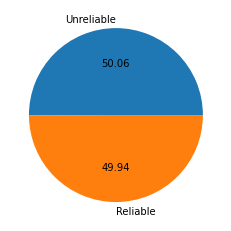

In [14]:

y = np.array([unreliable_count,reliable_count])
mylabels = ['Unreliable','Reliable']
plt.pie(y,labels=mylabels,autopct='%.2f')
plt.show()

In [15]:
df_train['len_text'] = df_train['text'].apply(lambda x : len(x))

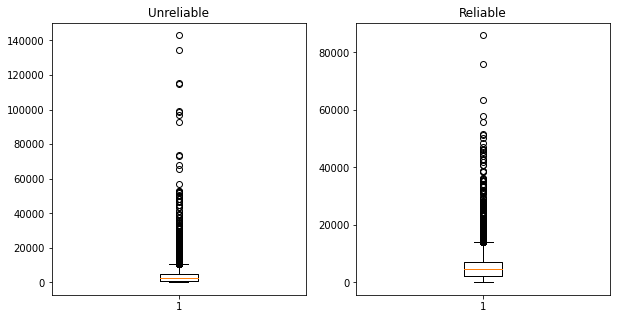

In [16]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.boxplot(df_train[df_train['label']==1]['len_text'])
ax1.set_title('Unreliable')
ax2.boxplot(df_train[df_train['label']==0]['len_text'])
ax2.set_title('Reliable')

plt.show()

**Unreliable news generally includes less words than Reliable****

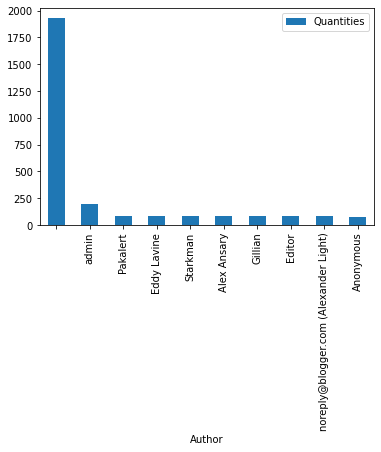

In [17]:
unreliable_author = pd.DataFrame({'Author':df_train[df_train['label']==1]['author'].value_counts().head(10).index,'Quantities':df_train[df_train['label']==1]['author'].value_counts().head(10)})

unreliable_author.plot(kind='bar',x='Author',y='Quantities')

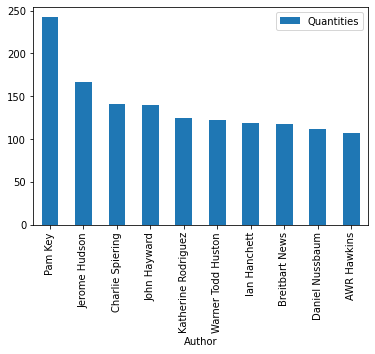

In [18]:
reliable_author = pd.DataFrame({'Author':df_train[df_train['label']==0]['author'].value_counts().head(10).index,'Quantities':df_train[df_train['label']==0]['author'].value_counts().head(10)})

reliable_author.plot(kind='bar',x='Author',y='Quantities')

In [19]:


df_train.columns

Index(['id', 'title', 'author', 'text', 'label', 'total', 'len_text'], dtype='object')

In [20]:


df = df_train.drop(columns= ['id','title','author','len_text', 'text'], axis = 1)

In [21]:
df_test.columns

Index(['id', 'title', 'author', 'text', 'total'], dtype='object')

In [22]:

df_test = df_test.drop(columns = ['title','author','text'])

In [23]:
df_test.head()

,id,total
0,20800,"Specter of Trump Loosens Tongues, if Not Purse..."
1,20801,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ..."
4,20804,Keiser Report: Meme Wars (E995)Truth Broadcast...


In [24]:
df.head()

,label,total
0,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,1,Why the Truth Might Get You FiredConsortiumnew...
3,1,15 Civilians Killed In Single US Airstrike Hav...
4,1,Iranian woman jailed for fictional unpublished...


In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [34]:
ps = PorterStemmer()
def preprocess_data(data):
    review = re.sub('[^a-zA-Z]',' ',data) # filtering out miscellaneous text.
    review = review.lower()
    review = review.split()
    review = [ps.stem(words) for words in review if words not in stopwords.words('english') and words.isalpha()]
    review = ' '.join(review)
    return review

In [30]:
from nltk.corpus import stopwords

In [35]:
df['clean_total'] = df['total'].apply(preprocess_data)
df_test['clean_total'] = df_test['total'].apply(preprocess_data)

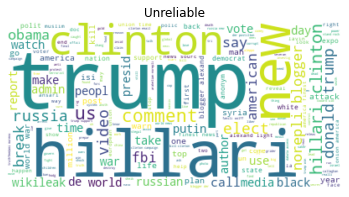

In [36]:
wc = WordCloud(background_color = 'white')
wc.generate(' '.join(df[df['label']==1]['clean_total']))
plt.imshow(wc,interpolation = 'bilinear')
plt.title('Unreliable')
plt.axis('off')
plt.show()

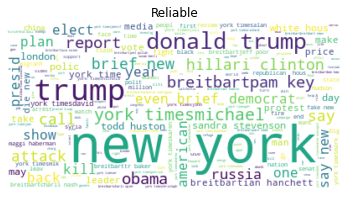

In [37]:
wc1= WordCloud(background_color = 'white')
wc1.generate(' '.join(df[df['label']==0]['clean_total']))
plt.imshow(wc1,interpolation = 'bilinear')
plt.title('Reliable')
plt.axis('off')
plt.show()

In [38]:
class config:
    DEVICE = device
    BATCH_SIZE = 50
    EPOCHS = 10
    VOCAB_SIZE = 1001
    OUTPUT_DIM = 1
    HIDDEN_DIM = 256
    PADDING_LEN = 500
    EMBEDDING_LEN = 64
    NO_OF_LAYERS = 2
    LEARNING_RATE = 0.001

In [39]:
X,y = df['total'].values,df['label'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)

In [40]:
from collections import Counter

def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tokcenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label == 1 else 0 for label in y_train]  
    encoded_test = [1 if label == 1 else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [41]:
x_train,y_train,x_test,y_test,vocab = tokcenize(x_train,y_train,x_test,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [42]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


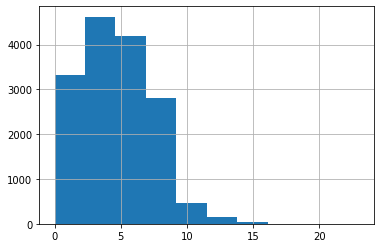

count    15600.000000
mean         4.635064
std          2.642144
min          0.000000
25%          3.000000
50%          4.000000
75%          6.000000
max         23.000000
dtype: float64

In [43]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [44]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [45]:
x_train_pad = padding_(x_train,config.PADDING_LEN)
x_test_pad = padding_(x_test,config.PADDING_LEN)

In [46]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=config.BATCH_SIZE)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=config.BATCH_SIZE)

In [47]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,   1,   2, 616],
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   1,   2, 245],
        ...,
        [  0,   0,   0,  ...,   0,   3, 254],
        [  0,   0,   0,  ..., 128,  32,  20],
        [  0,   0,   0,  ..., 456, 292, 681]])
Sample input: 
 tensor([0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 0])


In [53]:
class RNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(RNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [54]:
vocab_size = len(vocab) + 1
output_dim = 1
model = RNN(config.NO_OF_LAYERS,vocab_size,config.HIDDEN_DIM,config.EMBEDDING_LEN,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

RNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [60]:
lr=config.LEARNING_RATE
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    label.float()
    return torch.sum(pred == label.squeeze()).item()

In [66]:
lip = 5
epochs = 12 
clip = 5
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        pred = torch.round(output.squeeze())
        
        accuracy = torch.sum(pred == labels.float().squeeze()).item()
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            pred = torch.round(output.squeeze())
        
            accuracy = torch.sum(pred == labels.float().squeeze()).item()
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.06995261459945677 val_loss : 0.11649422260681884
train_accuracy : 97.87179487179488 val_accuracy : 96.71153846153845
Validation loss decreased (inf --> 0.116494).  Saving model ...
Epoch 2
train_loss : 0.05365044158847573 val_loss : 0.11866665672278032
train_accuracy : 98.3974358974359 val_accuracy : 96.5
Epoch 3
train_loss : 0.03791281476375074 val_loss : 0.13950331247178838
train_accuracy : 98.89102564102565 val_accuracy : 96.65384615384616
Epoch 4
train_loss : 0.026927038669199623 val_loss : 0.16099960806493002
train_accuracy : 99.18589743589745 val_accuracy : 96.1923076923077
Epoch 5
train_loss : 0.021876141659492695 val_loss : 0.1777483579107166
train_accuracy : 99.39102564102565 val_accuracy : 95.90384615384615
Epoch 6
train_loss : 0.019668325698241975 val_loss : 0.18773906454533482
train_accuracy : 99.38461538461539 val_accuracy : 96.65384615384616
Epoch 7
train_loss : 0.018352482183101343 val_loss : 0.20055916128722645
train_accuracy : 99.40384615384616 v

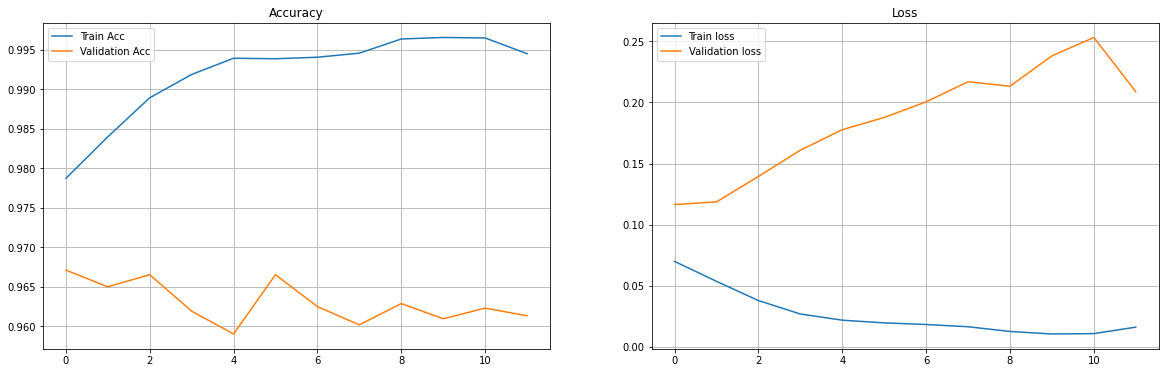

In [67]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [68]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())